# **Beamsearch**

This tutorial aims to introduce you to the concept of beam search, which is applied on top of encoder-decoder speech recognizers. The speech recognizer outputs a set of probabilities over the considered tokens (such as characters or BPE tokens). Our goal is to convert these probabilities into a final sequence of tokens output by the speech recognizer.

The simplest solution is to output the token with the highest probability at each decoding step. This method is known as **greedy search**.

However, an alternative approach is to explore different candidate solutions at each decoding step and keep track of the most promising solutions. Only at the final decoding step we choose the output sequence with the highest probability.
This method is called **beamsearch**.

Note that the best solution found by beam search is often different from the one found by the greedy search. Even if a partial solution is the best up to a certain decoding step, it may not be the best at the end of decoding.

Beamsearch is more computationally demanding than greedy search, but it generally helps improve performance. By exploring different hypotheses, we have the opportunity to rescore these hypotheses with a language model. In this way, the partial hypotheses that are plausible from both an acoustic and linguistic point of view are favored over the others.

In the following figure, we show how we can perform beamsearch using an RNN-based encoder-decoder speech recognizer (with an autoregressive decoder):






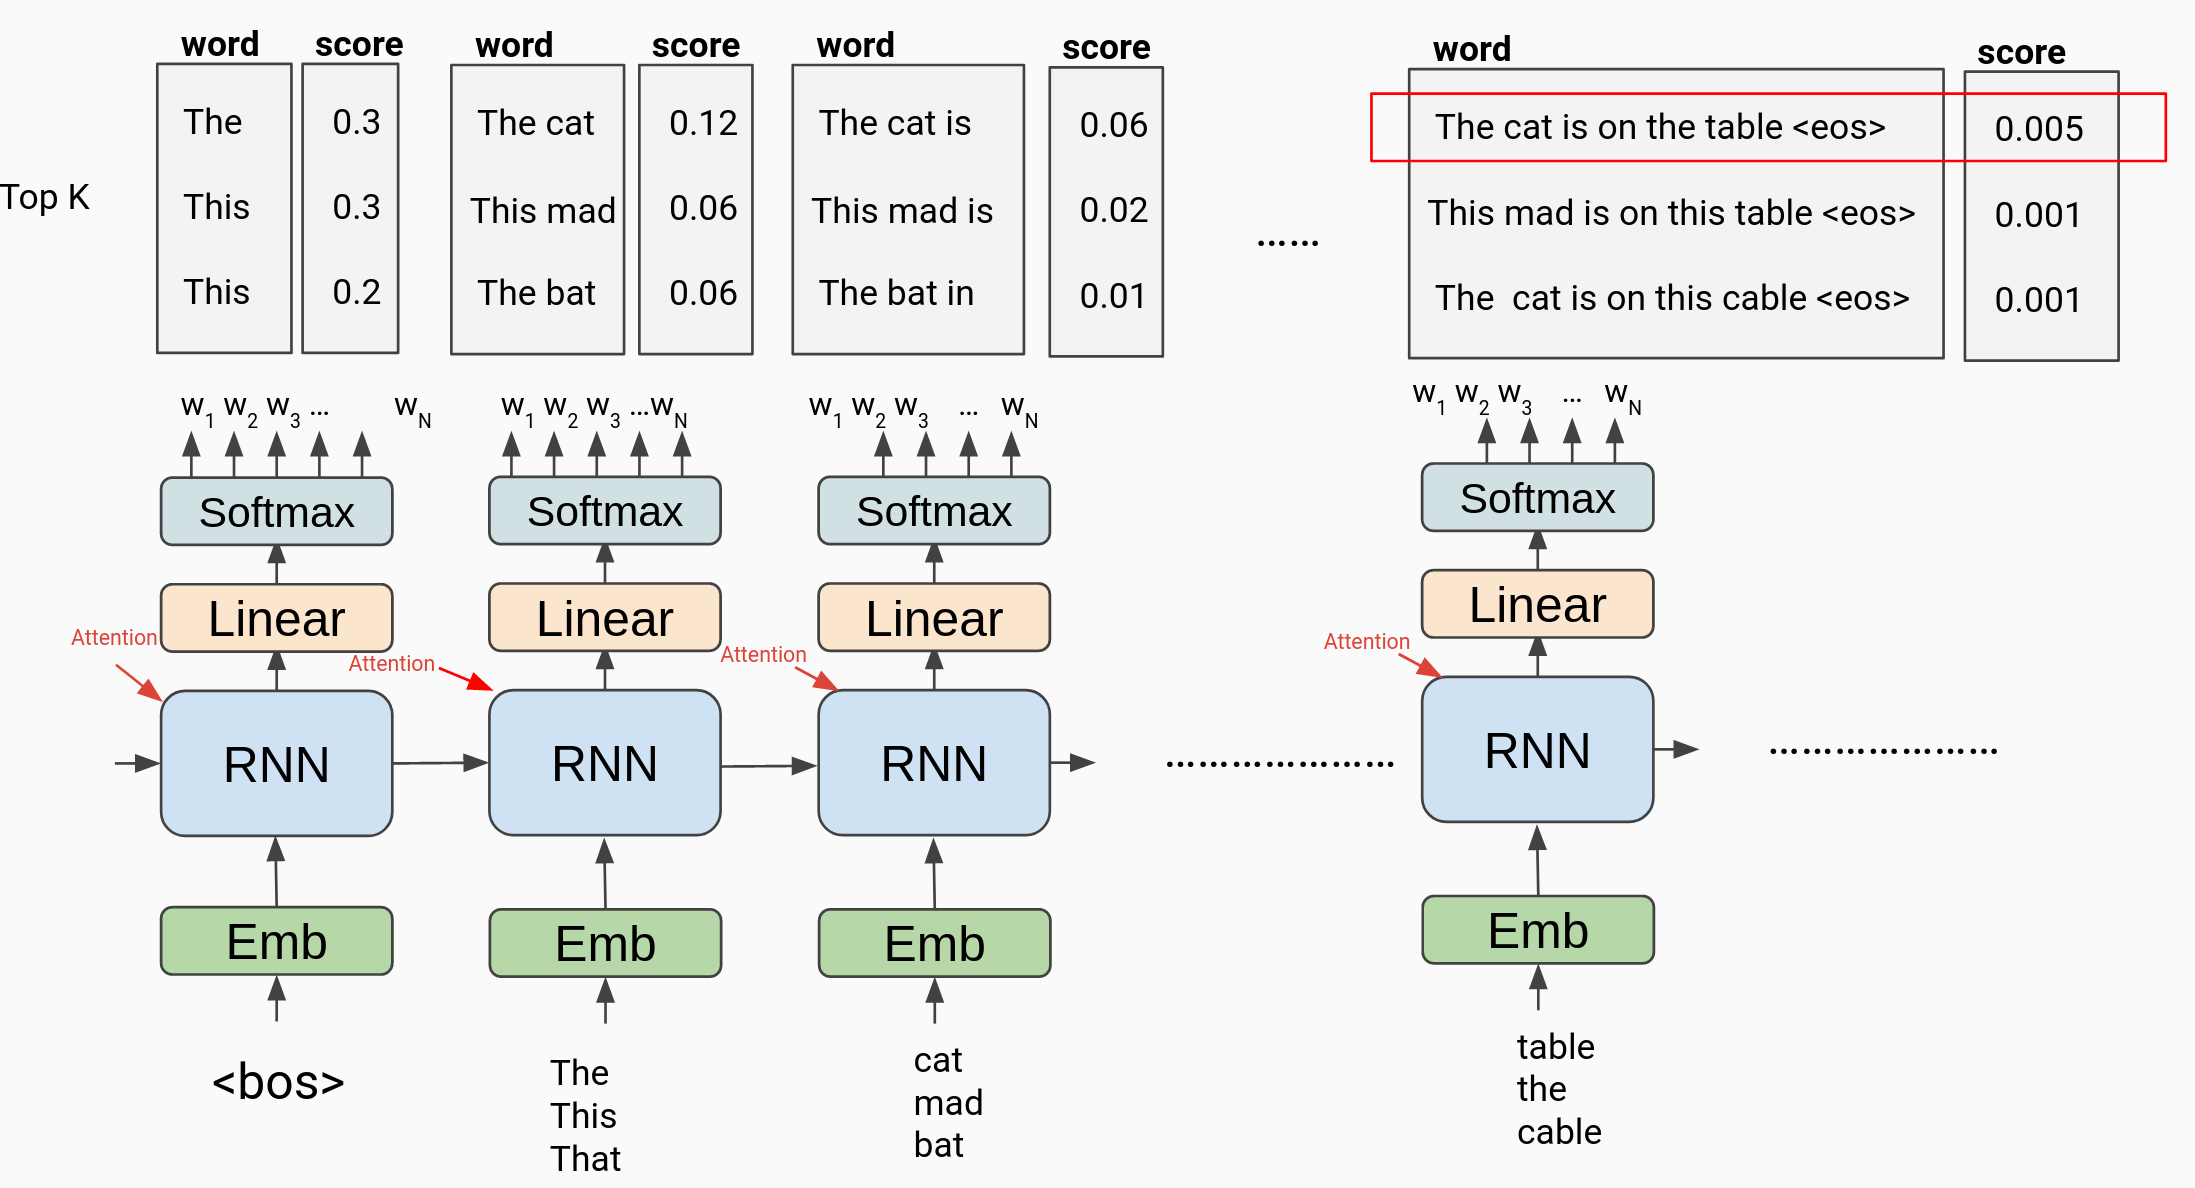

The Beamsearch algortihm works in this way:

1. At the first decoding step, we select the best K alternatives.

2.     Feed the K-best hypothesis in the next decoding step.

3.     Take the best K hypothesis over the set of N * K hypothesis explored.

4.     Repeat 2 until the end-of-sentence-token is predicted.


Let's take a closer look at the beamsearch implementation available in SpeechBrain. In this case, we will be using a pre-trained Automatic Speech Recognition (ASR) model, and we will be inputting some test signals into it. Our aim here is to demonstrate how the most critical hyperparameters of beamsearch can impact the quality of the transcription that is produced by the speech recognizer.

First, let's download some test data from the LibriSpeech dataset:


In [ ]:
!wget https://www.openslr.org/resources/12/test-clean.tar.gz

--2025-03-16 19:01:07--  https://www.openslr.org/resources/12/test-clean.tar.gz
Resolving www.openslr.org (www.openslr.org)... 46.101.158.64
Connecting to www.openslr.org (www.openslr.org)|46.101.158.64|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://openslr.elda.org/resources/12/test-clean.tar.gz [following]
--2025-03-16 19:01:07--  https://openslr.elda.org/resources/12/test-clean.tar.gz
Resolving openslr.elda.org (openslr.elda.org)... 141.94.109.138, 2001:41d0:203:ad8a::
Connecting to openslr.elda.org (openslr.elda.org)|141.94.109.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 346663984 (331M) [application/x-gzip]
Saving to: ‘test-clean.tar.gz’

test-clean.tar.gz   100%[===================>] 330.60M  18.1MB/s    in 21s     

2025-03-16 19:01:29 (16.1 MB/s) - ‘test-clean.tar.gz’ saved [346663984/346663984]



We need to untar the files with the following command:

In [ ]:
!tar -zxf test-clean.tar.gz

Let's install SpeechBrain:

In [ ]:
%%capture
!git clone https://github.com/speechbrain/speechbrain.git
%cd speechbrain
!pip install -r requirements.txt
!pip install .
%cd ..

Finally, we have to prepare the data manifest file for our test data.

In [ ]:
import json
import torchaudio
from speechbrain.utils.data_utils import get_all_files


def create_json(data_folder, json_file):
  json_dict = {}
  wav_lst = get_all_files(data_folder, match_and=[".flac"])
  txt_lst = get_all_files(data_folder, match_and=[".trans.txt"])
  txt_dict = text_to_dict(txt_lst)

  for wav_file in wav_lst:
    audioinfo = torchaudio.info(wav_file)
    duration = audioinfo.num_frames / audioinfo.sample_rate
    snt_id = wav_file.split('/')[-1].split('.flac')[0]

    # Create entry for this utterance
    json_dict[snt_id] = {
            "path": wav_file,
            "duration": duration,
            "wrd": txt_dict[snt_id]
            }

  # Writing the dictionary to the json file
  with open(json_file, mode="w") as json_f:
    json.dump(json_dict, json_f, indent=2)


def text_to_dict(text_lst):
    # Initialization of the text dictionary
    text_dict = {}
    # Reading all the transcription files is text_lst
    for file in text_lst:
        with open(file, "r") as f:
            # Reading all line of the transcription file
            for line in f:
                line_lst = line.strip().split(" ")
                text_dict[line_lst[0]] = "_".join(line_lst[1:])
    return text_dict


create_json('LibriSpeech/test-clean','test.json')


DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _speechbrain_save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _speechbrain_load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _recover


## **Beamsearch in SpeechBrain**
SpeechBrain provides a library in `speechbrain.decoders` that includes a range of beamsearch algorithms, from basic to more complex ones. In our specific case, we are working with an encoder-decoder architecture that uses Recurrent Neural Networks (RNNs). To perform inference with a pre-trained model and incorporate a pre-trained language model into the beam search process, we will need to utilize the `speechbrain.decoders.S2SRNNBeamSearcher` class. For more details on this class, please refer to the documentation available [here](speechbrain.decoders.S2SRNNBeamSearcher).

To set up all the necessary modules for performing inference with a pre-trained model and a pre-trained language model within the beam search algorithm, we will need to configure the following hyperparameter.

In [ ]:
%%file hparams.yaml

# Seed needs to be set at top of yaml, before objects with parameters
output_folder: !ref results/CRDNN/
wer_file: !ref <output_folder>/wer.txt
save_folder: !ref <output_folder>/save

# Tokenizer (# Fetches from HuggingFace https://huggingface.co/speechbrain)
pretrained_asr_path: speechbrain/asr-crdnn-rnnlm-librispeech
tokenizer_path: speechbrain/asr-crdnn-rnnlm-librispeech

# Data files
json_file: test.json

# Select only n_sentences (for computational efficiency)
select_n: 32
batch_size: 2

# Feature parameters
sample_rate: 16000
n_fft: 400
n_mels: 40

test_dataloader_opts:
   batch_size: !ref <batch_size>

# Model parameters
activation: !name:torch.nn.LeakyReLU
dropout: 0.15
cnn_blocks: 2
cnn_channels: (128, 256)
inter_layer_pooling_size: (2, 2)
cnn_kernelsize: (3, 3)
time_pooling_size: 4
rnn_class: !name:speechbrain.nnet.RNN.LSTM
rnn_layers: 4
rnn_neurons: 1024
rnn_bidirectional: True
dnn_blocks: 2
dnn_neurons: 512
emb_size: 128
dec_neurons: 1024
output_neurons: 1000  # Number of tokens (same as LM)
blank_index: 0
bos_index: 0
eos_index: 0

# Decoding parameters
min_decode_ratio: 0.0
max_decode_ratio: 1.0
test_beam_size: 1.0
eos_threshold: 1.5
using_max_attn_shift: True
max_attn_shift: 240
temperature: 1.25
temperature_lm: 1.25

# Scoring parameters
lm_weight: 0.0
coverage_penalty: 1.5



normalize: !new:speechbrain.processing.features.InputNormalization
   norm_type: global

compute_features: !new:speechbrain.lobes.features.Fbank
   sample_rate: !ref <sample_rate>
   n_fft: !ref <n_fft>
   n_mels: !ref <n_mels>

enc: !new:speechbrain.lobes.models.CRDNN.CRDNN
   input_shape: [null, null, !ref <n_mels>]
   activation: !ref <activation>
   dropout: !ref <dropout>
   cnn_blocks: !ref <cnn_blocks>
   cnn_channels: !ref <cnn_channels>
   cnn_kernelsize: !ref <cnn_kernelsize>
   inter_layer_pooling_size: !ref <inter_layer_pooling_size>
   time_pooling: True
   using_2d_pooling: False
   time_pooling_size: !ref <time_pooling_size>
   rnn_class: !ref <rnn_class>
   rnn_layers: !ref <rnn_layers>
   rnn_neurons: !ref <rnn_neurons>
   rnn_bidirectional: !ref <rnn_bidirectional>
   rnn_re_init: True
   dnn_blocks: !ref <dnn_blocks>
   dnn_neurons: !ref <dnn_neurons>
   use_rnnp: False

emb: !new:speechbrain.nnet.embedding.Embedding
   num_embeddings: !ref <output_neurons>
   embedding_dim: !ref <emb_size>

dec: !new:speechbrain.nnet.RNN.AttentionalRNNDecoder
   enc_dim: !ref <dnn_neurons>
   input_size: !ref <emb_size>
   rnn_type: gru
   attn_type: location
   hidden_size: !ref <dec_neurons>
   attn_dim: 1024
   num_layers: 1
   scaling: 1.0
   channels: 10
   kernel_size: 100
   re_init: True
   dropout: !ref <dropout>

ctc_lin: !new:speechbrain.nnet.linear.Linear
   input_size: !ref <dnn_neurons>
   n_neurons: !ref <output_neurons>

seq_lin: !new:speechbrain.nnet.linear.Linear
   input_size: !ref <dec_neurons>
   n_neurons: !ref <output_neurons>

seq_cost: !name:speechbrain.nnet.losses.nll_loss
   label_smoothing: 0.1

log_softmax: !new:speechbrain.nnet.activations.Softmax
   apply_log: True


lm_model: !new:speechbrain.lobes.models.RNNLM.RNNLM
   output_neurons: !ref <output_neurons>
   embedding_dim: !ref <emb_size>
   activation: !name:torch.nn.LeakyReLU
   dropout: 0.0
   rnn_layers: 2
   rnn_neurons: 2048
   dnn_blocks: 1
   dnn_neurons: 512
   return_hidden: True  # For inference

tokenizer: !new:sentencepiece.SentencePieceProcessor

# Models
modules:
   enc: !ref <enc>
   emb: !ref <emb>
   dec: !ref <dec>
   ctc_lin: !ref <ctc_lin>
   seq_lin: !ref <seq_lin>
   normalize: !ref <normalize>
   lm_model: !ref <lm_model>

model: !new:torch.nn.ModuleList
   - [!ref <enc>, !ref <emb>, !ref <dec>, !ref <ctc_lin>, !ref <seq_lin>]


coverage_scorer: !new:speechbrain.decoders.scorer.CoverageScorer
   vocab_size: !ref <output_neurons>

rnnlm_scorer: !new:speechbrain.decoders.scorer.RNNLMScorer
   language_model: !ref <lm_model>
   temperature: !ref <temperature_lm>

scorer: !new:speechbrain.decoders.scorer.ScorerBuilder
   full_scorers: [!ref <rnnlm_scorer>,
                  !ref <coverage_scorer>]
   weights:
      rnnlm: !ref <lm_weight>
      coverage: !ref <coverage_penalty>

beam_search: !new:speechbrain.decoders.S2SRNNBeamSearcher
   embedding: !ref <emb>
   decoder: !ref <dec>
   linear: !ref <seq_lin>
   bos_index: !ref <bos_index>
   eos_index: !ref <eos_index>
   min_decode_ratio: !ref <min_decode_ratio>
   max_decode_ratio: !ref <max_decode_ratio>
   beam_size: !ref <test_beam_size>
   eos_threshold: !ref <eos_threshold>
   using_max_attn_shift: !ref <using_max_attn_shift>
   max_attn_shift: !ref <max_attn_shift>
   temperature: !ref <temperature>
   scorer: !ref <scorer>

error_rate_computer: !name:speechbrain.utils.metric_stats.ErrorRateStats

cer_computer: !name:speechbrain.utils.metric_stats.ErrorRateStats
   split_tokens: True

# The pretrainer allows a mapping between pretrained files and instances that
# are declared in the yaml. E.g here, we will download the file asr.ckpt
# and it will be loaded into "model" which is pointing to the <model> defined
# before.
pretrainer: !new:speechbrain.utils.parameter_transfer.Pretrainer
   collect_in: !ref <save_folder>
   loadables:
      model: !ref <model>
      lm_model: !ref <lm_model>
      tokenizer: !ref <tokenizer>
      normalize: !ref <normalize>
   paths:
      model: !ref <pretrained_asr_path>/asr.ckpt
      lm_model: !ref <pretrained_asr_path>/lm.ckpt
      tokenizer: !ref <tokenizer_path>/tokenizer.ckpt
      normalize: !ref <pretrained_asr_path>/normalizer.ckpt

Writing hparams.yaml


The following script combines all the basic building blocks declared in the yaml file and performs inference on the given test set:

In [ ]:
%%file eval.py

import os
import sys
import torch
import logging
import speechbrain as sb
from speechbrain.utils.distributed import run_on_main
from hyperpyyaml import load_hyperpyyaml
from pathlib import Path

logger = logging.getLogger(__name__)


# Define training procedure
class ASR(sb.Brain):
    def compute_forward(self, batch, stage):
        """Forward computations from the waveform batches to the output probabilities."""
        batch = batch.to(self.device)
        wavs, wav_lens = batch.sig
        tokens_bos, _ = batch.tokens_bos
        wavs, wav_lens = wavs.to(self.device), wav_lens.to(self.device)

        # Forward pass
        feats = self.hparams.compute_features(wavs)
        feats = self.modules.normalize(feats, wav_lens)
        x = self.modules.enc(feats.detach())
        e_in = self.modules.emb(tokens_bos)  # y_in bos + tokens
        h, _ = self.modules.dec(e_in, x, wav_lens)

        # Output layer for seq2seq log-probabilities
        logits = self.modules.seq_lin(h)
        p_seq = self.hparams.log_softmax(logits)

        # Compute outputs
        p_tokens, _, _, _ = self.hparams.beam_search(x, wav_lens)

        return p_seq, wav_lens, p_tokens

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss (CTC+NLL) given predictions and targets."""

        p_seq, wav_lens, predicted_tokens = predictions
        ids = batch.id
        tokens_eos, tokens_eos_lens = batch.tokens_eos
        tokens, tokens_lens = batch.tokens

        loss = self.hparams.seq_cost(
            p_seq, tokens_eos, length=tokens_eos_lens
        )

        # Decode token terms to words
        predicted_words = [
                self.tokenizer.decode_ids(utt_seq).split(" ")
                for utt_seq in predicted_tokens
            ]
        target_words = [wrd.split("_") for wrd in batch.wrd]
        self.wer_metric.append(ids, predicted_words, target_words)
        self.cer_metric.append(ids, predicted_words, target_words)

        return loss

    def evaluate_batch(self, batch, stage):
        """Computations needed for validation/test batches"""
        predictions = self.compute_forward(batch, stage=stage)
        with torch.no_grad():
            loss = self.compute_objectives(predictions, batch, stage=stage)
        return loss.detach()

    def on_stage_start(self, stage, epoch):
        """Gets called at the beginning of each epoch"""
        if stage != sb.Stage.TRAIN:
            self.cer_metric = self.hparams.cer_computer()
            self.wer_metric = self.hparams.error_rate_computer()

    def on_stage_end(self, stage, stage_loss, epoch):
        """Gets called at the end of a epoch."""
        # Compute/store important stats
        stage_stats = {"loss": stage_loss}
        stage_stats["CER"] = self.cer_metric.summarize("error_rate")
        stage_stats["WER"] = self.wer_metric.summarize("error_rate")
        print(stage_stats)
        with open(self.hparams.wer_file, "w") as w:
          self.wer_metric.write_stats(w)


def dataio_prepare(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions."""
    test_data = sb.dataio.dataset.DynamicItemDataset.from_json(
        json_path=hparams["json_file"],
    )
    test_data = test_data.filtered_sorted(sort_key="duration",  select_n=hparams["select_n"])
    datasets = [test_data]

    # We get the tokenizer as we need it to encode the labels when creating
    # mini-batches.
    tokenizer = hparams["tokenizer"]

    # 2. Define audio pipeline:
    @sb.utils.data_pipeline.takes("path")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(path):
        sig = sb.dataio.dataio.read_audio(path)
        return sig

    sb.dataio.dataset.add_dynamic_item(datasets, audio_pipeline)

    # 3. Define text pipeline:
    @sb.utils.data_pipeline.takes("wrd")
    @sb.utils.data_pipeline.provides(
        "wrd", "tokens_list", "tokens_bos", "tokens_eos", "tokens"
    )
    def text_pipeline(wrd):
        yield wrd
        tokens_list = tokenizer.encode_as_ids(wrd)
        yield tokens_list
        tokens_bos = torch.LongTensor([hparams["bos_index"]] + (tokens_list))
        yield tokens_bos
        tokens_eos = torch.LongTensor(tokens_list + [hparams["eos_index"]])
        yield tokens_eos
        tokens = torch.LongTensor(tokens_list)
        yield tokens

    sb.dataio.dataset.add_dynamic_item(datasets, text_pipeline)

    # 4. Set output:
    sb.dataio.dataset.set_output_keys(
        datasets, ["id", "sig", "wrd", "tokens_bos", "tokens_eos", "tokens"],
    )

    return test_data


if __name__ == "__main__":

    # CLI:
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])

    # Load hparams
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # here we create the datasets objects as well as tokenization and encoding
    test_data = dataio_prepare(hparams)

    # We download the pretrained ASR from HuggingFace (or elsewhere depending on
    # the path given in the YAML file). The tokenizer is loaded at the same time.
    run_on_main(hparams["pretrainer"].collect_files)
    hparams["pretrainer"].load_collected()

    # Trainer initialization
    asr_brain = ASR(
        modules=hparams["modules"],
        hparams=hparams,
        run_opts=run_opts,
    )

    # We dynamicaly add the tokenizer to our brain class.
    # NB: This tokenizer corresponds to the one used for the ASR models.
    asr_brain.tokenizer = hparams["tokenizer"]

    # Testing
    asr_brain.evaluate(
        test_data,
        min_key="WER",
        test_loader_kwargs=hparams["test_dataloader_opts"],
    )

Writing eval.py


## **Effect of the Beam Size**

The beam size is the number of alternative transcriptions that the algorithm maintains at each decoding step. By increasing the beam size, we explore more possible transcriptions, which may lead to better performance.

However, a larger beam size also results in increased computational complexity, which in turn slows down the search algorithm and requires more memory. Therefore, selecting the appropriate beam size is a critical hyperparameter to ensure optimal performance without sacrificing computational efficiency.


Let's examine what happens when we use a simple greedy search, which can be accomplished by setting the beam size to 1:

In [ ]:
!python eval.py hparams.yaml  --test_beam_size=1

/usr/local/lib/python3.11/dist-packages/speechbrain/utils/autocast.py:68: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)
speechbrain.utils.quirks - Applied quirks (see `speechbrain.utils.quirks`): [disable_jit_profiling, allow_tf32]
speechbrain.utils.quirks - Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/CRDNN/
speechbrain.utils.fetching - Fetch asr.ckpt: Fetching from HuggingFace Hub 'speechbrain/asr-crdnn-rnnlm-librispeech' if not cached
asr.ckpt: 100% 480M/480M [00:03<00:00, 130MB/s]
speechbrain.utils.fetching - Fetch lm.ckpt: Fetching from HuggingFace Hub 'speechbrain/asr-crdnn-rnnlm-librispeech' if not cached
lm.ckpt: 100% 212M/212M [00:01<00:00, 135MB/s]
speechbrain.utils.fetching - Fetch

With greedy search, we achieved a very high word error rate (WER) of about 18\%.
Let's now increase the beam size and set it to 64:

In [ ]:
!python eval.py hparams.yaml  --lm_weight=0.0 --test_beam_size=64

/usr/local/lib/python3.11/dist-packages/speechbrain/utils/autocast.py:68: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)
speechbrain.utils.quirks - Applied quirks (see `speechbrain.utils.quirks`): [disable_jit_profiling, allow_tf32]
speechbrain.utils.quirks - Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/CRDNN/
speechbrain.utils.fetching - Fetch asr.ckpt: Using symlink found at '/content/results/CRDNN/save/model.ckpt'
speechbrain.utils.fetching - Fetch lm.ckpt: Using symlink found at '/content/results/CRDNN/save/lm_model.ckpt'
speechbrain.utils.fetching - Fetch tokenizer.ckpt: Using symlink found at '/content/results/CRDNN/save/tokenizer.ckpt'
speechbrain.utils.fetching - Fetch normalizer.ckpt:

Thanks to beamsearch, we have an important performance gain. Now, the model reaches a WER of about 10\%.

We can plot the performance achieved when progressively increasing the beam size:


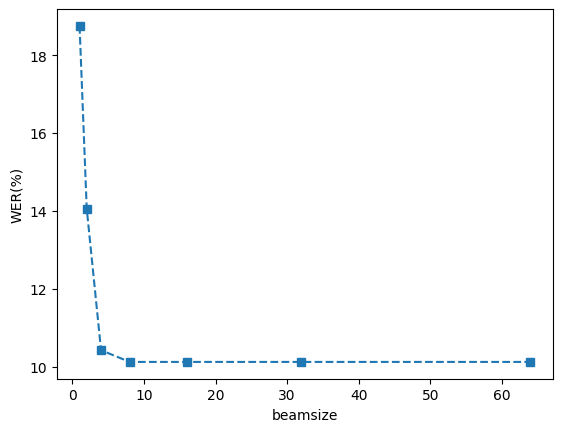

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# X axis parameter:
xaxis = np.array([1, 2,4,8,16,32,64])

# Y axis parameter:
yaxis = np.array([18.75, 14.06, 10.43, 10.13, 10.13, 10.13, 10.13])
plt.xlabel("beamsize")
plt.ylabel("WER(%)")
plt.plot(xaxis, yaxis,'--s')
plt.show()

From the figure above it emerges how important is to carefully set the beam size. In this case, we can see that a beam size of 64 minimizes the word error rate. So, we will use a beam size of 64 for the next experiments.

## **Impact of the Language Model**

The language model can be utilized to rescore the partial hypotheses. Alongside the decoder, we also operate a language model RNN that assigns a score to each hypothesis. We then combine the acoustic and language scores using linear interpolation and choose the top-k options. It's crucial to tune the weight assigned to the language model probabilities (`lm_weight`), as it significantly impacts performance. Let's see its effects on performance.

Let't start with a `lm_weight` of 0.5:

In [ ]:
!python eval.py hparams.yaml  --lm_weight=0.4 --test_beam_size=64

/usr/local/lib/python3.11/dist-packages/speechbrain/utils/autocast.py:68: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)
speechbrain.utils.quirks - Applied quirks (see `speechbrain.utils.quirks`): [disable_jit_profiling, allow_tf32]
speechbrain.utils.quirks - Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/CRDNN/
speechbrain.utils.fetching - Fetch asr.ckpt: Using symlink found at '/content/results/CRDNN/save/model.ckpt'
speechbrain.utils.fetching - Fetch lm.ckpt: Using symlink found at '/content/results/CRDNN/save/lm_model.ckpt'
speechbrain.utils.fetching - Fetch tokenizer.ckpt: Using symlink found at '/content/results/CRDNN/save/tokenizer.ckpt'
speechbrain.utils.fetching - Fetch normalizer.ckpt:

You can see that the language model helps a lot to improve performance. Without a language model, we have a WER of 10\%, while here we now at 7.5\%.
Let's see what happens if we increase `lm_weight`.

In [ ]:
!python eval.py hparams.yaml  --lm_weight=1.0 --test_beam_size=64

/usr/local/lib/python3.11/dist-packages/speechbrain/utils/autocast.py:68: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)
speechbrain.utils.quirks - Applied quirks (see `speechbrain.utils.quirks`): [disable_jit_profiling, allow_tf32]
speechbrain.utils.quirks - Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/CRDNN/
speechbrain.utils.fetching - Fetch asr.ckpt: Using symlink found at '/content/results/CRDNN/save/model.ckpt'
speechbrain.utils.fetching - Fetch lm.ckpt: Using symlink found at '/content/results/CRDNN/save/lm_model.ckpt'
speechbrain.utils.fetching - Fetch tokenizer.ckpt: Using symlink found at '/content/results/CRDNN/save/tokenizer.ckpt'
speechbrain.utils.fetching - Fetch normalizer.ckpt:

If we increase too much the weight assigned to the language model, however, the performance starts to deteriorate (in this case we got WER=14.37\%). In a good ASR, we have to carefully find the right balance between acoustic and language information.

Here we show the performance observed when changing `lm_weight`:

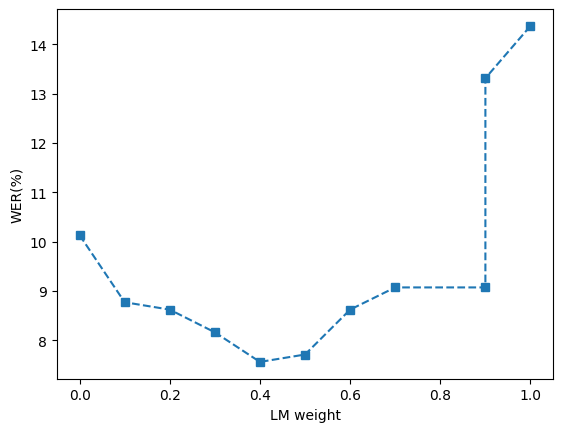

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# X axis parameter:
xaxis = np.array([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.9,0.9,1.0])

# Y axis parameter:
yaxis = np.array([10.13, 8.77, 8.62, 8.16, 7.56, 7.71, 8.62, 9.07, 9.07, 13.31, 14.37])
plt.xlabel("LM weight")
plt.ylabel("WER(%)")
plt.plot(xaxis, yaxis,'--s')
plt.show()

Setting a good value for `lm_weight` is crucial. In this case, a weight of 0.6 minimizes the word error rate.

## **Other Beamsearch Hyperparameters**

Beam search algorithms frequently employ a set of heuristics aimed at enhancing their performance. However, several of these heuristics require the specification of certain hyperparameters.

### End-of-Sentence Threshold
One such hyperparameter is `eos_threshold`. This parameter is used to steer the search towards shorter or longer transcriptions. In practice, lower values of `eos_threshold ` prioritize longer sentences as the probability of the `<eos>` token is penalized relative to the other tokens. Conversely, higher values of eos_threshold push the system to generate shorter sentences as the probability of the `<eos>` token is amplified. For more information on the significance of this hyperparameter, please refer to [this paper](https://arxiv.org/pdf/1904.02619.pdf).


Let's see what happens when we set `eos_threshold` to 1.0 (before it was 1.5):

In [ ]:
!python eval.py hparams.yaml  --lm_weight=0.4 --test_beam_size=64 --eos_threshold=1.0

/usr/local/lib/python3.11/dist-packages/speechbrain/utils/autocast.py:68: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)
speechbrain.utils.quirks - Applied quirks (see `speechbrain.utils.quirks`): [allow_tf32, disable_jit_profiling]
speechbrain.utils.quirks - Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/CRDNN/
speechbrain.utils.fetching - Fetch asr.ckpt: Using symlink found at '/content/results/CRDNN/save/model.ckpt'
speechbrain.utils.fetching - Fetch lm.ckpt: Using symlink found at '/content/results/CRDNN/save/lm_model.ckpt'
speechbrain.utils.fetching - Fetch tokenizer.ckpt: Using symlink found at '/content/results/CRDNN/save/tokenizer.ckpt'
speechbrain.utils.fetching - Fetch normalizer.ckpt:

We can see a significant degradation of the performance. When the model emits the `<eos>` token too late, it results in the generation of repetitive sentences, as illustrated in this example:


```
================================================================================
8555-284447-0016, %WER 1000.00 [ 20 / 2, 20 ins, 0 del, 0 sub ]
FINE ; GLORIOUS ; <eps> ;  <eps>   ; <eps> ;  <eps>   ; <eps> ; <eps> ;  <eps>   ; <eps> ;  <eps>   ; <eps> ; <eps> ;  <eps>   ; <eps> ;  <eps>   ; <eps> ; <eps> ; <eps> ;  <eps>   ;  <eps>  ; <eps>
 =   ;    =     ;   I   ;    I     ;   I   ;    I     ;   I   ;   I   ;    I     ;   I   ;    I     ;   I   ;   I   ;    I     ;   I   ;    I     ;   I   ;   I   ;   I   ;    I     ;    I    ;   I  
FINE ; GLORIOUS ;  ROSE ; GLORIOUS ;  ROSE ; GLORIOUS ;   IN  ;  FINE ; GLORIOUS ;  ROSE ; GLORIOUS ;   IN  ;  FINE ; GLORIOUS ;  ROSE ; GLORIOUS ;   IN  ;  THE  ;  FINE ; GLORIOUS ; RESPLOR ;   YO
================================================================================
```



Let's now set the `eos_threshold` to a very high value:

In [ ]:
!python eval.py hparams.yaml  --lm_weight=0.4 --test_beam_size=64 --eos_threshold=100.0

/usr/local/lib/python3.11/dist-packages/speechbrain/utils/autocast.py:68: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)
speechbrain.utils.quirks - Applied quirks (see `speechbrain.utils.quirks`): [allow_tf32, disable_jit_profiling]
speechbrain.utils.quirks - Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/CRDNN/
speechbrain.utils.fetching - Fetch asr.ckpt: Using symlink found at '/content/results/CRDNN/save/model.ckpt'
speechbrain.utils.fetching - Fetch lm.ckpt: Using symlink found at '/content/results/CRDNN/save/lm_model.ckpt'
speechbrain.utils.fetching - Fetch tokenizer.ckpt: Using symlink found at '/content/results/CRDNN/save/tokenizer.ckpt'
speechbrain.utils.fetching - Fetch normalizer.ckpt:

Here the effect is the opposite. As they tend to emit the <eos> token pretty early, we end up with several deletions in our transcription.



```
8555-284447-0015, %WER 67.80 [ 40 / 59, 0 ins, 40 del, 0 sub ]
THEY ; LOOK ; SOMETHING ; ALIKE ; YOU ; KNOW ; SUGGESTED ; THE ; CAPTAIN ; OF ; THE ; GUARDS ; LOOKING ; FROM ; ONE ; TO ; THE ; OTHER ; DOUBTFULLY ;  AND  ; THEY'RE ; NEARLY ;  THE  ;  SAME ;  SIZE ;   IF  ;  YOU  ; STAND ;  THE  ;  GOAT ;   ON  ;  HIS  ;  HIND ;  LEGS ; THEY'VE ;  BOTH ;  GOT  ;  THE  ;  SAME ; STYLE ;   OF  ; WHISKERS ;  AND  ; THEY'RE ;  BOTH ;   OF  ;   EM  ; OBSTINATE ;  AND  ; DANGEROUS ;   SO  ;  THEY ; OUGHT ;   TO  ;  MAKE ;   A   ;  GOOD ; PATCH ; SPLENDID
 =   ;  =   ;     =     ;   =   ;  =  ;  =   ;     =     ;  =  ;    =    ; =  ;  =  ;   =    ;    =    ;  =   ;  =  ; =  ;  =  ;   =   ;     =      ;   D   ;    D    ;   D    ;   D   ;   D   ;   D   ;   D   ;   D   ;   D   ;   D   ;   D   ;   D   ;   D   ;   D   ;   D   ;    D    ;   D   ;   D   ;   D   ;   D   ;   D   ;   D   ;    D     ;   D   ;    D    ;   D   ;   D   ;   D   ;     D     ;   D   ;     D     ;   D   ;   D   ;   D   ;   D   ;   D   ;   D   ;   D   ;   D   ;    D    
THEY ; LOOK ; SOMETHING ; ALIKE ; YOU ; KNOW ; SUGGESTED ; THE ; CAPTAIN ; OF ; THE ; GUARDS ; LOOKING ; FROM ; ONE ; TO ; THE ; OTHER ; DOUBTFULLY ; <eps> ;  <eps>  ; <eps>  ; <eps> ; <eps> ; <eps> ; <eps> ; <eps> ; <eps> ; <eps> ; <eps> ; <eps> ; <eps> ; <eps> ; <eps> ;  <eps>  ; <eps> ; <eps> ; <eps> ; <eps> ; <eps> ; <eps> ;  <eps>   ; <eps> ;  <eps>  ; <eps> ; <eps> ; <eps> ;   <eps>   ; <eps> ;   <eps>   ; <eps> ; <eps> ; <eps> ; <eps> ; <eps> ; <eps> ; <eps> ; <eps> ;  <eps>  

```



### Coverage Penalty

Another frequently used hyperparameter is the `coverage penalty`, which serves to encourage the model to focus on distinct elements while discouraging it from attending repeatedly to the same elements. This is accomplished by tracking the cumulative attention on the various hypotheses and penalizing hypotheses that revisit previously attended time steps. For more information on the coverage penalty and its effects, please refer to this [paper](https://arxiv.org/pdf/1612.02695.pdf).

Let's see what happens if we set the `coverage_penalty` to -10.0 (before it was 1.5):

In [ ]:
!python eval.py hparams.yaml  --lm_weight=0.4 --test_beam_size=64 --coverage_penalty=-10.0

/usr/local/lib/python3.11/dist-packages/speechbrain/utils/autocast.py:68: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)
speechbrain.utils.quirks - Applied quirks (see `speechbrain.utils.quirks`): [disable_jit_profiling, allow_tf32]
speechbrain.utils.quirks - Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/CRDNN/
speechbrain.utils.fetching - Fetch asr.ckpt: Using symlink found at '/content/results/CRDNN/save/model.ckpt'
speechbrain.utils.fetching - Fetch lm.ckpt: Using symlink found at '/content/results/CRDNN/save/lm_model.ckpt'
speechbrain.utils.fetching - Fetch tokenizer.ckpt: Using symlink found at '/content/results/CRDNN/save/tokenizer.ckpt'
speechbrain.utils.fetching - Fetch normalizer.ckpt:

You may observe a decline in performance, since attending to the same encoded states repeatedly can lead to multiple insertion errors, as shown in this example:

```
8555-284447-0002, %WER 282.61 [ 65 / 23, 59 ins, 0 del, 6 sub ]
I ; WOULDN'T ; MIND ;  A  ;   CUP    ;   O    ; <eps>  ; <eps> ; <eps> ; <eps> ; <eps> ; <eps> ; <eps> ; <eps> ; <eps>  ; COFFEE ; MYSELF ; SAID ; CAP'N ; BILL ; <eps> ; <eps> ; <eps> ; <eps> ; <eps>  ; <eps>  ; <eps>  ; <eps> ; <eps> ; <eps> ; <eps> ; <eps> ; <eps> ; <eps> ; <eps>  ; <eps>  ; <eps>  ; <eps> ; <eps> ; <eps> ; <eps> ; <eps> ; <eps> ; <eps> ; <eps>  ; <eps>  ; <eps>  ; <eps> ; <eps> ; <eps> ; <eps> ; <eps> ; <eps> ; <eps> ; <eps>  ; <eps>  ; <eps>  ; <eps> ; <eps> ; <eps> ; <eps> ; <eps> ; <eps> ; <eps> ; <eps>  ; <eps>  ; <eps>  ; <eps> ; <eps> ; <eps> ; I'VE ; HAD ;  CONSID'BLE  ; EXERCISE ; THIS ; MORNIN ; AND ; I'M ; ALL ; READY ; FOR ;  BREAKFAS
= ;    S     ;  =   ;  S  ;    S     ;   S    ;   I    ;   I   ;   I   ;   I   ;   I   ;   I   ;   I   ;   I   ;   I    ;   =    ;   =    ;  =   ;   =   ;  =   ;   I   ;   I   ;   I   ;   I   ;   I    ;   I    ;   I    ;   I   ;   I   ;   I   ;   I   ;   I   ;   I   ;   I   ;   I    ;   I    ;   I    ;   I   ;   I   ;   I   ;   I   ;   I   ;   I   ;   I   ;   I    ;   I    ;   I    ;   I   ;   I   ;   I   ;   I   ;   I   ;   I   ;   I   ;   I    ;   I    ;   I    ;   I   ;   I   ;   I   ;   I   ;   I   ;   I   ;   I   ;   I    ;   I    ;   I    ;   I   ;   I   ;   I   ;  =   ;  =  ;      S       ;    =     ;  =   ;   =    ;  =  ;  =  ;  =  ;   =   ;  =  ;     S    
I ;  WON'T   ; MIND ; THE ; COUPLE'S ; COFFEE ; MYSELF ;  SAID ; CAP'N ;  BILL ;   I   ; DON'T ;  MIND ;  THE  ; COUPLE ; COFFEE ; MYSELF ; SAID ; CAP'N ; BILL ;   I   ; DON'T ;  MIND ;  THE  ; COUPLE ; COFFEE ; MYSELF ;  SAID ; CAP'N ;  BILL ;   I   ; DON'T ;  MIND ;  THE  ; COUPLE ; COFFEE ; MYSELF ;  SAID ; CAP'N ;  BILL ;   I   ; DON'T ;  MIND ;  THE  ; COUPLE ; COFFEE ; MYSELF ;  SAID ; CAP'N ;  BILL ;   I   ; DON'T ;  MIND ;  THE  ; COUPLE ; COFFEE ; MYSELF ;  SAID ; CAP'N ;  BILL ;   I   ; DON'T ;  MIND ;  THE  ; COUPLE ; COFFEE ; MYSELF ;  SAID ; CAP'N ;  BILL ; I'VE ; HAD ; CONSIDERABLE ; EXERCISE ; THIS ; MORNIN ; AND ; I'M ; ALL ; READY ; FOR ; BREAKFAST
================================================================================

```



What happens if we increase the coverage penalty?

In [ ]:
!python eval.py hparams.yaml  --lm_weight=1.0 --test_beam_size=64 --coverage_penalty=10000.0

/usr/local/lib/python3.11/dist-packages/speechbrain/utils/autocast.py:68: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)
speechbrain.utils.quirks - Applied quirks (see `speechbrain.utils.quirks`): [allow_tf32, disable_jit_profiling]
speechbrain.utils.quirks - Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/CRDNN/
speechbrain.utils.fetching - Fetch asr.ckpt: Using symlink found at '/content/results/CRDNN/save/model.ckpt'
speechbrain.utils.fetching - Fetch lm.ckpt: Using symlink found at '/content/results/CRDNN/save/lm_model.ckpt'
speechbrain.utils.fetching - Fetch tokenizer.ckpt: Using symlink found at '/content/results/CRDNN/save/tokenizer.ckpt'
speechbrain.utils.fetching - Fetch normalizer.ckpt:

In this case, the risk is to add many deletion errors:



```
8555-284447-0015, %WER 67.80 [ 40 / 59, 0 ins, 40 del, 0 sub ]
THEY ; LOOK ; SOMETHING ; ALIKE ; YOU ; KNOW ; SUGGESTED ; THE ; CAPTAIN ; OF ; THE ; GUARDS ; LOOKING ; FROM ; ONE ; TO ; THE ; OTHER ; DOUBTFULLY ;  AND  ; THEY'RE ; NEARLY ;  THE  ;  SAME ;  SIZE ;   IF  ;  YOU  ; STAND ;  THE  ;  GOAT ;   ON  ;  HIS  ;  HIND ;  LEGS ; THEY'VE ;  BOTH ;  GOT  ;  THE  ;  SAME ; STYLE ;   OF  ; WHISKERS ;  AND  ; THEY'RE ;  BOTH ;   OF  ;   EM  ; OBSTINATE ;  AND  ; DANGEROUS ;   SO  ;  THEY ; OUGHT ;   TO  ;  MAKE ;   A   ;  GOOD ; PATCH ; SPLENDID
 =   ;  =   ;     =     ;   =   ;  =  ;  =   ;     =     ;  =  ;    =    ; =  ;  =  ;   =    ;    =    ;  =   ;  =  ; =  ;  =  ;   =   ;     =      ;   D   ;    D    ;   D    ;   D   ;   D   ;   D   ;   D   ;   D   ;   D   ;   D   ;   D   ;   D   ;   D   ;   D   ;   D   ;    D    ;   D   ;   D   ;   D   ;   D   ;   D   ;   D   ;    D     ;   D   ;    D    ;   D   ;   D   ;   D   ;     D     ;   D   ;     D     ;   D   ;   D   ;   D   ;   D   ;   D   ;   D   ;   D   ;   D   ;    D    
THEY ; LOOK ; SOMETHING ; ALIKE ; YOU ; KNOW ; SUGGESTED ; THE ; CAPTAIN ; OF ; THE ; GUARDS ; LOOKING ; FROM ; ONE ; TO ; THE ; OTHER ; DOUBTFULLY ; <eps> ;  <eps>  ; <eps>  ; <eps> ; <eps> ; <eps> ; <eps> ; <eps> ; <eps> ; <eps> ; <eps> ; <eps> ; <eps> ; <eps> ; <eps> ;  <eps>  ; <eps> ; <eps> ; <eps> ; <eps> ; <eps> ; <eps> ;  <eps>   ; <eps> ;  <eps>  ; <eps> ; <eps> ; <eps> ;   <eps>   ; <eps> ;   <eps>   ; <eps> ; <eps> ; <eps> ; <eps> ; <eps> ; <eps> ; <eps> ; <eps> ;  <eps>  

```



## **Hyperparameter Tuning**

As we have observed, beamsearch require numerous hyperparameters, some of which are pivotal in achieving optimal performance. Thus, it's essential to set them appropriately. One way to achieve this is by running a hyperparameter tuning algorithm such as grid search, random search, or Bayesian optimization on the validation set. It's important to note that hyperparameter tuning on the test set is considered cheating and should be avoided. Fortunately, you don't need to retrain the model from scratch. Instead, you can utilize your best pretrained model and perform inference with beam search.


